In [1]:
import pandas as pd
import numpy as np
from preprocess.config.config import Conf
from preprocess.clinical import ClinicalData
from preprocess.mutation import MutationData

from preprocess.config.patient_mappings import PatientMappings

from scipy.stats import gaussian_kde

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
clinical_data = ClinicalData(Conf.datasets['Clinical'])
clinical_data.preprocess_data()

In [3]:
patient_mappings = PatientMappings(clinical_data()['patient_id'])

In [4]:
clinical_data()['pathologic_stage'].isna().sum()

0

In [5]:
mutation_data = MutationData(Conf.datasets['Mutation'])
mutation_data.add_stage_data(clinical_data)
mutation_data.clean_data()

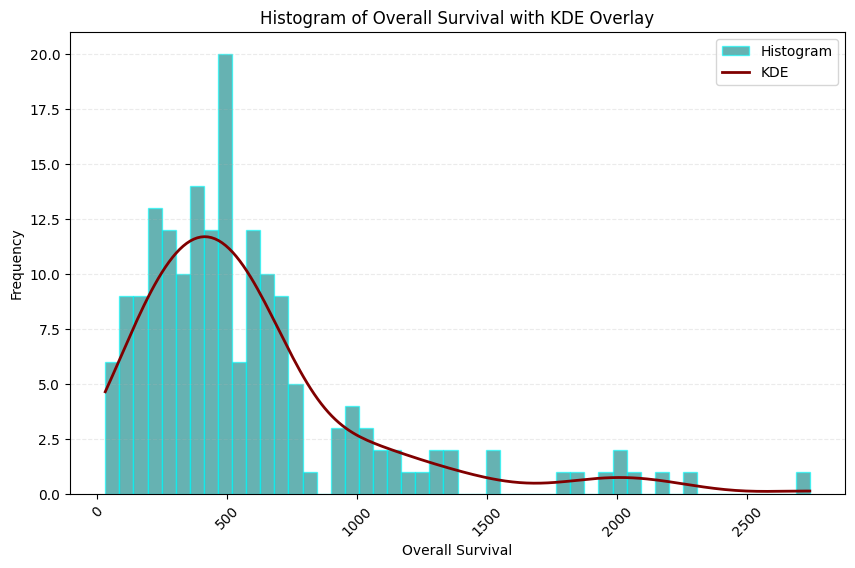

In [6]:
data = clinical_data()['overall_survival']

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(data, bins=50, edgecolor='aqua', color='teal', alpha=0.6, label="Histogram")

kde = gaussian_kde(data)

x = np.linspace(np.min(data), np.max(data), 200)

kde_values = kde(x)

bin_width = bins[1] - bins[0]
kde_scaled = kde_values * len(data) * bin_width

plt.plot(x, kde_scaled, color='maroon', linewidth=2, label='KDE')

plt.xticks(rotation=45)
plt.xlabel("Overall Survival")
plt.ylabel("Frequency")
plt.title("Histogram of Overall Survival with KDE Overlay")
plt.grid(axis="y", linestyle="--", alpha=0.25)
plt.legend()
plt.show()

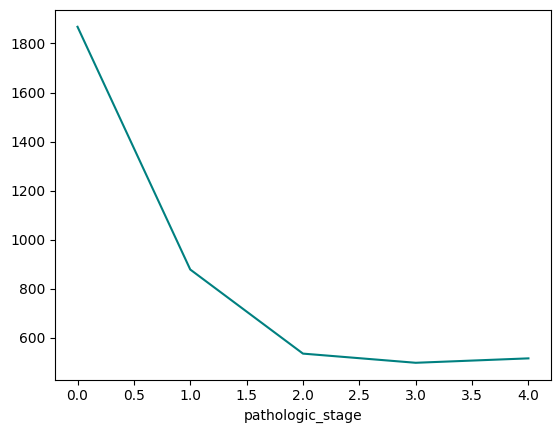

In [7]:
clinical_data().groupby('pathologic_stage')['overall_survival'].mean().plot(color="teal")
plt.show()

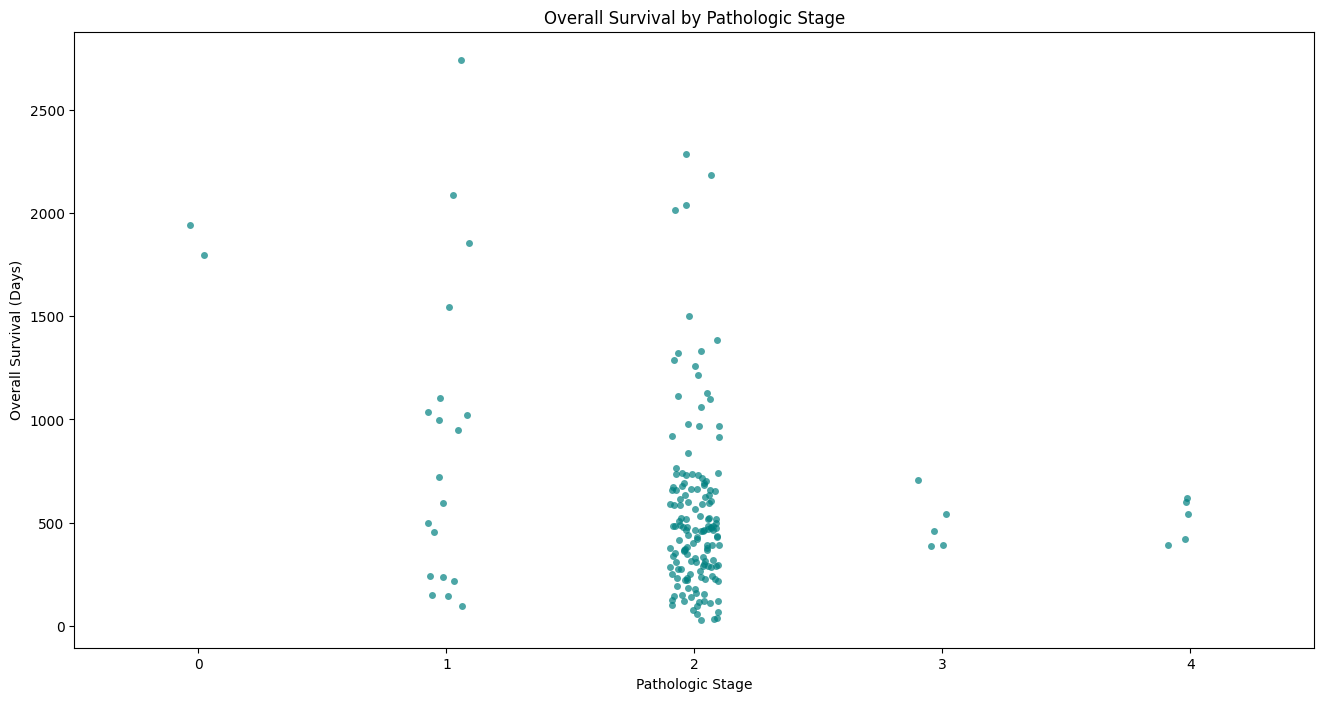

In [8]:
plt.figure(figsize=(16, 8))

# sns.boxplot(x='pathologic_stage', y='overall_survival', data=clinical_data())
sns.stripplot(x='pathologic_stage', y='overall_survival', data=clinical_data(), color='teal', alpha=0.7)

plt.title("Overall Survival by Pathologic Stage")
plt.xlabel("Pathologic Stage")
plt.ylabel("Overall Survival (Days)")
plt.show()

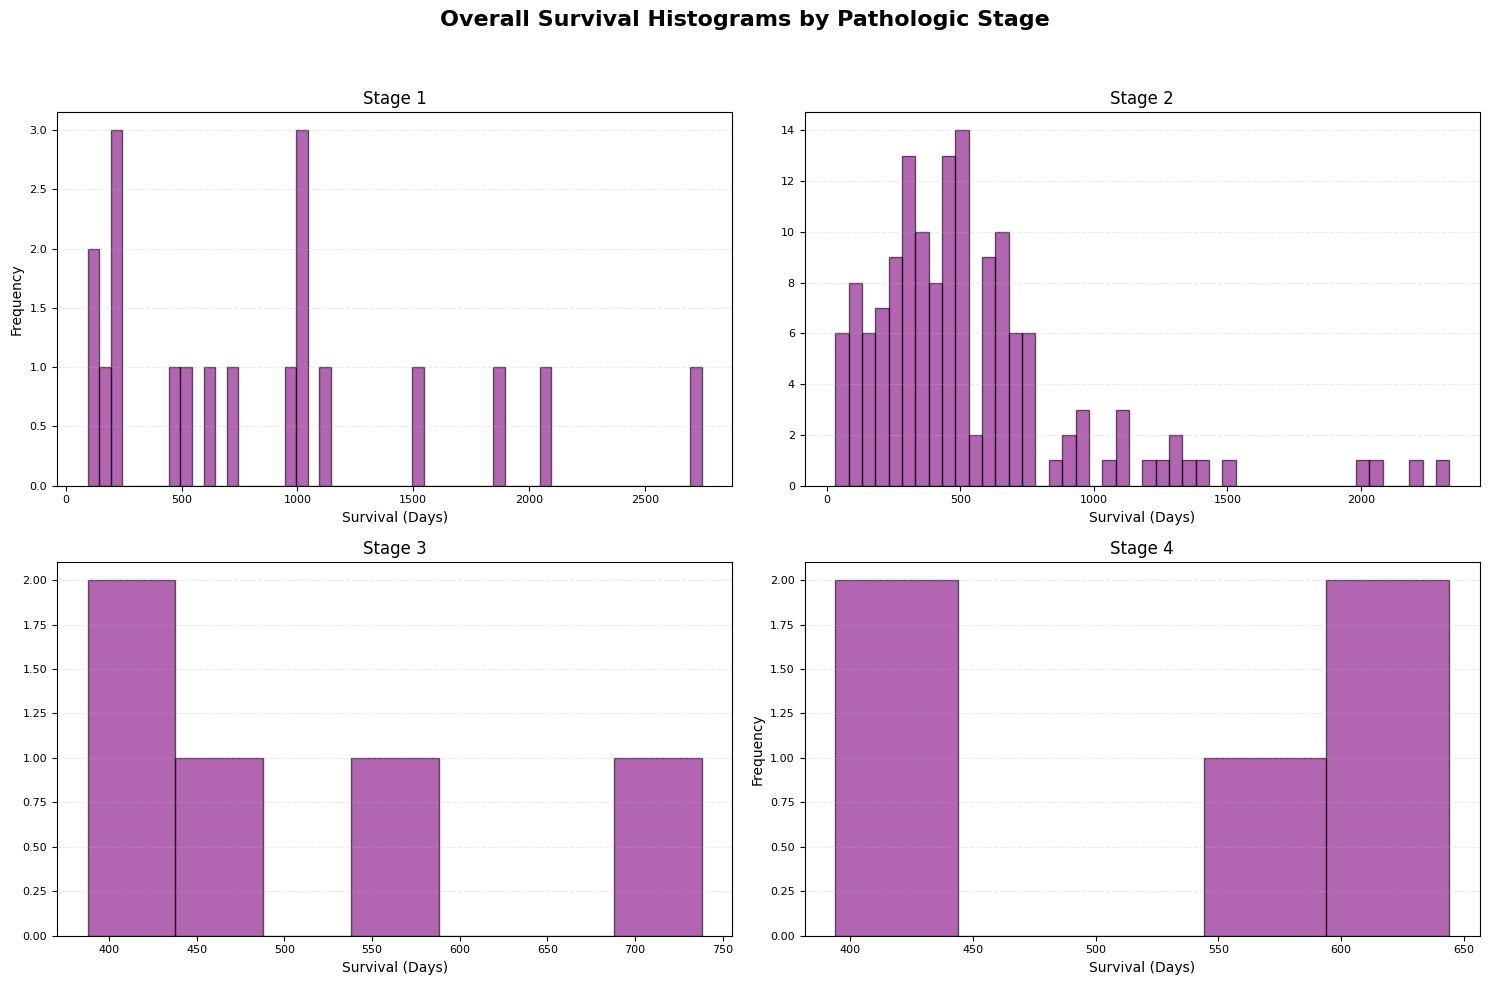

In [9]:
c_data = clinical_data()[['overall_survival', 'pathologic_stage']]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Overall Survival Histograms by Pathologic Stage", fontsize=16, fontweight="bold")

axes = axes.flatten()

for i in range(4):
    data = c_data[c_data['pathologic_stage'] == i + 1]['overall_survival']
    data = pd.to_numeric(data, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    
    ax = axes[i]
    ax.hist(data, bins=range(int(min(data)), int(max(data)) + 50, 50), color="purple", edgecolor="black", alpha=0.6)
    ax.set_title(f"Stage {i + 1}", fontsize=12)
    ax.set_xlabel("Survival (Days)", fontsize=10)
    if i == 0 or i == 3:
        ax.set_ylabel("Frequency", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

  0%|          | 0/2317 [00:00<?, ?it/s]

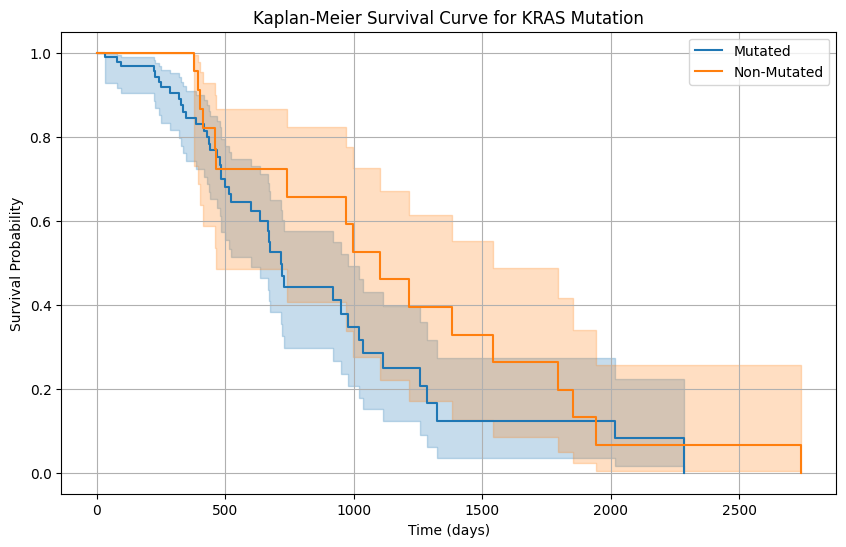

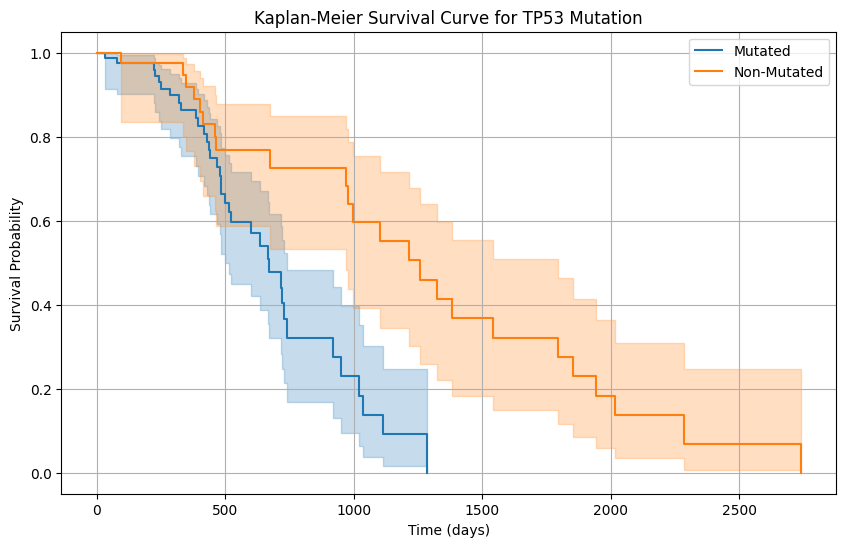

In [18]:
df = mutation_data()

significant_genes = []
p_value_threshold = 0.1
min_group_size = 20

for gene in tqdm(mutation_data().columns[1:-3]):    
    mutated = df[df[gene] == 1]
    non_mutated = df[df[gene] == 0]

    if len(mutated) < min_group_size or len(non_mutated) < min_group_size:
        continue

    results_logrank = logrank_test(
        mutated["overall_survival"], non_mutated["overall_survival"],
        event_observed_A=mutated["status"], event_observed_B=non_mutated["status"]
    )

    if results_logrank.p_value < p_value_threshold:
        significant_genes.append({
            "gene": gene,
            "mutated_count": len(mutated),
            "non_mutated_count": len(non_mutated),
            "mutated_mean_survival": mutated['overall_survival'].mean(),
            "non_mutated_mean_survival": non_mutated['overall_survival'].mean(),
            "p_value": results_logrank.p_value,
        })
    
        kmf = KaplanMeierFitter()
        
        plt.figure(figsize=(10, 6))
        kmf.fit(mutated["overall_survival"], event_observed=1-mutated["status"], label="Mutated")
        kmf.plot_survival_function()
        
        kmf.fit(non_mutated["overall_survival"], event_observed=1-non_mutated["status"], label="Non-Mutated")
        kmf.plot_survival_function()
        
        plt.title(f"Kaplan-Meier Survival Curve for {gene} Mutation")
        plt.xlabel("Time (days)")
        plt.ylabel("Survival Probability")
        plt.legend()
        plt.grid(True)
        plt.show()

In [19]:
significant_genes_df = pd.DataFrame(significant_genes)
significant_genes_df

,gene,mutated_count,non_mutated_count,mutated_mean_survival,non_mutated_mean_survival,p_value
0,KRAS,96,25,524.531250,898.920,0.011261
1,TP53,81,40,452.333333,904.725,0.004520
